In [11]:
import pandas as pd
from serpapi import GoogleSearch
import datetime
from google.cloud import bigquery
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from dotenv import load_dotenv

load_dotenv() 

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'credentials.json'
API_KEY = os.getenv("API_KEY")

In [ ]:
search_term = "data analyst"
search_location = "Singapore"
    
for i in range(45):
  start = i * 10
  params = {
    "api_key": API_KEY,
    "engine": "google_jobs",
    "google_domain": "google.com.sg",
    "q": search_term,
    "hl": "en",
    "gl": "sg",
    "location": search_location,
    "start": start
  }
  
  search = GoogleSearch(params)
  results = search.get_dict()
  # check if the last search page (i.e., no results)
  try:
      if results['error'] == "Google hasn't returned any results for this query.":
          break
  except KeyError:
      print(f"Getting SerpAPI data for page: {start}")
  else:
      continue
    
  jobs = results['jobs_results']
  jobs = pd.DataFrame(jobs)
  jobs = pd.concat([pd.DataFrame(jobs), 
                  pd.json_normalize(jobs['detected_extensions'])], 
                  axis=1).drop('detected_extensions', axis=1)
  jobs['date_time'] = datetime.datetime.utcnow()

  # concat dataframe
  if start == 0:
      jobs_all = jobs
  else:
      jobs_all = pd.concat([jobs_all, jobs])

  jobs_all['search_term'] = search_term
  jobs_all['search_location'] = search_location



Getting SerpAPI data for page: 0
Getting SerpAPI data for page: 10
Getting SerpAPI data for page: 20
Getting SerpAPI data for page: 30
Getting SerpAPI data for page: 40
Getting SerpAPI data for page: 50
Getting SerpAPI data for page: 60
Getting SerpAPI data for page: 70
Getting SerpAPI data for page: 80
Getting SerpAPI data for page: 90
Getting SerpAPI data for page: 100
Getting SerpAPI data for page: 110
Getting SerpAPI data for page: 120
Getting SerpAPI data for page: 130
Getting SerpAPI data for page: 140
Getting SerpAPI data for page: 150
Getting SerpAPI data for page: 160
Getting SerpAPI data for page: 170
Getting SerpAPI data for page: 180
Getting SerpAPI data for page: 190
Getting SerpAPI data for page: 200
Getting SerpAPI data for page: 210
Getting SerpAPI data for page: 220
Getting SerpAPI data for page: 230
Getting SerpAPI data for page: 240


In [ ]:
jobs_all.reset_index(inplace = True)

In [ ]:
job_highlights = jobs_all['job_highlights'].to_dict()
extracted_highlights = {}
for k,v in job_highlights.items():
  items_list = [item_dict['items'] for item_dict in v][0][0]
  extracted_highlights[k] = items_list
  
descs = []
for k,desc in extracted_highlights.items():
  descs.append(desc)

In [ ]:
related_links = jobs_all['related_links'].to_dict()
extracted_links = {}
for k,v in related_links.items():
  items_list = [item_dict['link'] for item_dict in v][-1]
  extracted_links[k] = items_list
links = []
for k,link in extracted_links.items():
  links.append(link)

In [ ]:
extensions = jobs_all['extensions'].to_dict()
extracted_extensions = {}
for k,v in extensions.items():
  items_list = [item_dict for item_dict in v]
  if len(items_list) == 1:
    temp_list = []
    temp_list.append("None")
    temp_list.append(items_list[0])
    extracted_extensions[k] = temp_list
  elif len(items_list) == 0:
    temp_list = ["None", "None"]
    extracted_extensions[k] = temp_list
  else:
    extracted_extensions[k] = items_list

time = []
type = []
for k,v in extracted_extensions.items():
  time.append(v[0])
  type.append(v[1])

In [ ]:
len(time) == len(type) == len(descs) == len(links)

data = {
    'description': descs,
    'link': links
}
extracted_df = pd.DataFrame(data)
extracted_df.head()

,description,link
0,You will be part of Munich Re’s Regional AI/An...,https://www.google.com.sg/search?sca_esv=56030...
1,Be a Part of Something BIG!\n\nWe are seeking ...,https://www.google.com.sg/search?sca_esv=56030...
2,Are you an experienced Data Analyst with a pas...,https://www.google.com.sg/search?sca_esv=56030...
3,Job Title: Data Analyst\n\nJob description and...,https://www.google.com.sg/search?sca_esv=56030...
4,At AIA we've started an exciting movement to c...,https://www.google.com.sg/search?sca_esv=56030...


In [ ]:
# dropping columns
jobs_all = jobs_all[['title', 'company_name', 'location', 'via', 'job_id','posted_at', 'schedule_type', 'date_time', 'search_term',
       'search_location']]

jobs_df = pd.concat([jobs_all,extracted_df], axis = 1)

In [ ]:
jobs_df.head()

,title,company_name,location,via,job_id,posted_at,schedule_type,date_time,search_term,search_location,description,link
0,Data Analyst & BI Intern,Munich Re,Singapore,via LinkedIn,eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QgXHUwMDI2IE...,23 hours ago,Internship,2023-08-26 09:53:19.105632,data analyst,Singapore,You will be part of Munich Re’s Regional AI/An...,https://www.google.com.sg/search?sca_esv=56030...
1,Data Analyst,SINGAPORE TELECOMMUNICATIONS LIMITED,Singapore,via MyCareersFuture,eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QiLCJodGlkb2...,3 days ago,Full–time,2023-08-26 09:53:19.105632,data analyst,Singapore,Be a Part of Something BIG!\n\nWe are seeking ...,https://www.google.com.sg/search?sca_esv=56030...
2,Data Analyst - CAT 1 / G50 Clearance,Maltem Asia-Pacific,Singapore,via LinkedIn,eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QgLSBDQVQgMS...,1 day ago,Full–time,2023-08-26 09:53:19.105632,data analyst,Singapore,Are you an experienced Data Analyst with a pas...,https://www.google.com.sg/search?sca_esv=56030...
3,Data Analyst,U3 INFOTECH PTE. LTD.,Singapore,via JobsDB,eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QiLCJodGlkb2...,23 hours ago,Contractor,2023-08-26 09:53:19.105632,data analyst,Singapore,Job Title: Data Analyst\n\nJob description and...,https://www.google.com.sg/search?sca_esv=56030...
4,"Data Analyst, Advanced Operations Solutions",AIA Singapore Private Limited,Singapore,via Norway,eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QsIEFkdmFuY2...,24 hours ago,Full–time,2023-08-26 09:53:19.105632,data analyst,Singapore,At AIA we've started an exciting movement to c...,https://www.google.com.sg/search?sca_esv=56030...


In [ ]:
table_id = "linkedin-profile-392109.linkedin_jobs.jobs" # BigQuery Table name
client = bigquery.Client()
schema = client.schema_from_json('schema.json')
table = bigquery.Table(table_id, schema=schema)
table = client.create_table(table)  # Make an API request.
print(
    "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
)

Created table linkedin-profile-392109.linkedin_jobs.jobs


In [ ]:
errors = client.insert_rows_from_dataframe(table, jobs_df)
if errors == []:
    print("Data loaded into table")
else:
    print(errors)

[[]]


In [ ]:
# Storage of queries to fetch respective data

# QUERY = ('SELECT * FROM `linkedin-profile-392109.linkedin_jobs.linkedin-test-again` ')

def build_query(column: str, table: str):
  query = f'SELECT {column} FROM `{table}`'
  return query

def run_query(client, query):
  query_job = client.query(query)
  result = query_job.result()
  return result  

In [ ]:
# Build query to collect dataframe from table
FETCH_ALL_QUERY = build_query("*", "linkedin-profile-392109.linkedin_jobs.jobs")

tbl = run_query(client, FETCH_ALL_QUERY)

In [ ]:
df = client.query(FETCH_ALL_QUERY).to_dataframe()

In [ ]:
df.head()

,title,company_name,location,via,job_id,posted_at,schedule_type,date_time,search_term,search_location,description,link
0,Data Analyst,PAN-UNITED TECHNOLOGIES PTE. LTD.,Singapore,via Indeed,eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QiLCJodGlkb2...,16 hours ago,Full–time,2023-08-26 09:53:19.105632+00:00,data analyst,Singapore,Data analyst is responsible to gather and scru...,https://www.google.com.sg/search?sca_esv=56030...
1,Language Data Analyst,TRANSPERFECT TRANSLATIONS PTE. LTD.,Singapore,via Indeed,eyJqb2JfdGl0bGUiOiJMYW5ndWFnZSBEYXRhIEFuYWx5c3...,1 day ago,Contractor,2023-08-26 09:53:25.540901+00:00,data analyst,Singapore,Work Location: Onsite in SingaporeWork Schedul...,https://www.google.com.sg/search?sca_esv=56030...
2,Data Analyst (BANK),Adecco - GS,Singapore,via Indeed,eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QgKEJBTkspIi...,7 days ago,Contractor,2023-08-26 09:53:32.902583+00:00,data analyst,Singapore,Looking for a Data Analyst\n\nMNC/ BANK\n\n6 m...,https://www.google.com.sg/search?sca_esv=56030...
3,Data Analyst (BANK),Adecco - GS,Singapore,via Indeed,eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QgKEJBTkspIi...,7 days ago,Contractor,2023-08-26 09:53:36.042054+00:00,data analyst,Singapore,Looking for a Data Analyst\n\nMNC/ BANK\n\n6 m...,https://www.google.com.sg/search?sca_esv=56030...
4,Data Analyst,Finest People,Singapore,via Indeed,eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QiLCJodGlkb2...,None,Full–time,2023-08-26 09:53:43.146170+00:00,data analyst,Singapore,• Do you have a knowledge of digital marketing...,https://www.google.com.sg/search?sca_esv=56030...


In [ ]:
df['schedule_type'].value_counts().reset_index()

,schedule_type,count
0,Full–time,193
1,Contractor,24
2,Internship,22
3,Part-time,4


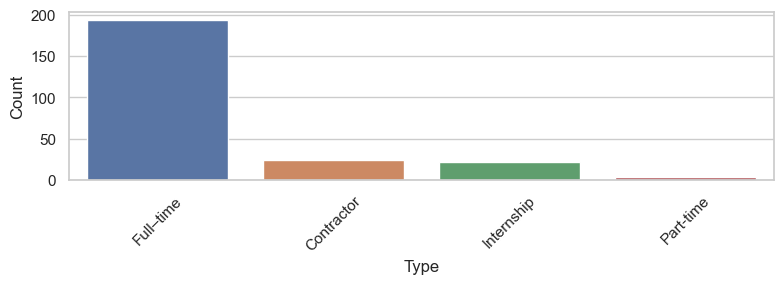

In [ ]:
plt.figure(figsize=(8, 3))  # Set the figure size
sns.set(style="whitegrid")
type_counts = df['schedule_type'].value_counts().reset_index()
sns.barplot(x='schedule_type', y="count", data= type_counts)

# Adding labels and title
plt.xlabel("Type")
plt.ylabel("Count")

# Rotate x-labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

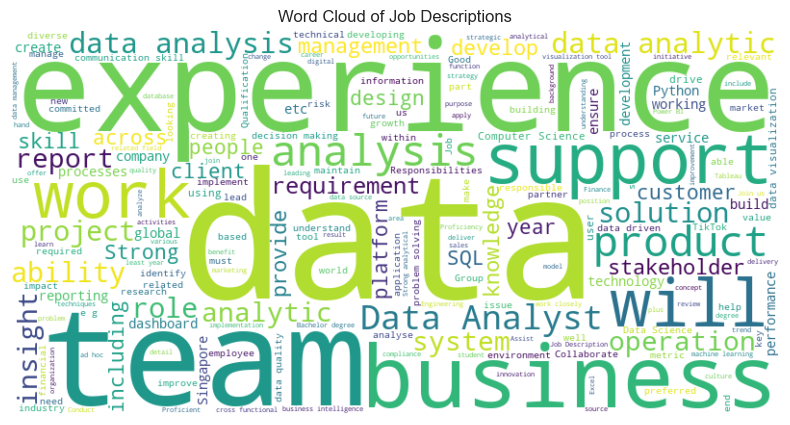

In [ ]:
# Combine all descriptions into a single string
all_descriptions = ' '.join(df['description'].dropna())

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(all_descriptions)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels and ticks
plt.title("Word Cloud of Job Descriptions")
plt.show()


In [ ]:
df['portal'] = df['via'].apply(lambda x: x.split(' ')[1].strip())

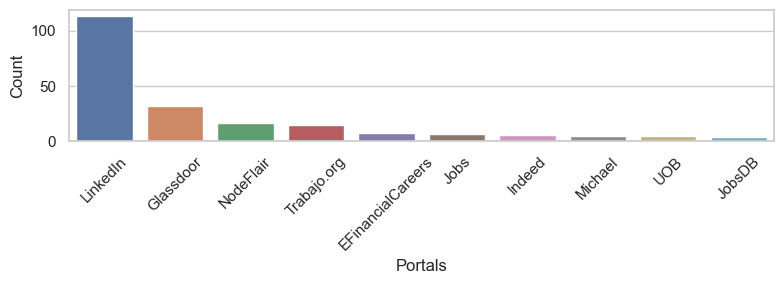

In [ ]:
plt.figure(figsize=(8, 3))  # Set the figure size
sns.set(style="whitegrid")
type_counts = df['portal'].value_counts().reset_index()[:10]
sns.barplot(x='portal', y="count", data= type_counts)

# Adding labels and title
plt.xlabel("Portals")
plt.ylabel("Count")

# Rotate x-labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()